In [2]:
import numpy as np
import torch
from torch import nn
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import models, transforms
from doodleLoaderSimple import DoodleDatasetSimple
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


## Training and validation for the house image classifier

In [3]:
class_dict = {
    0: 'Stress/Anxiety',
    1: 'Low self-esteem/Introvert/Withdrawn',
    2: 'High self-esteem/Extrovert/Fantasizing'
}

data = np.genfromtxt('D:/COLLEGE_STUDIES/SEM-6/ML_NLP_project/data/houseData.csv', dtype=int, delimiter=',', names=True)

df = pd.DataFrame(data)

print(df.head())

df['class_label'] = df['class'].map(class_dict)
df.head()

   id  class
0   0      0
1   1      1
2   2      2
3   3      0
4   4      1


,id,class,class_label
0,0,0,Stress/Anxiety
1,1,1,Low self-esteem/Introvert/Withdrawn
2,2,2,High self-esteem/Extrovert/Fantasizing
3,3,0,Stress/Anxiety
4,4,1,Low self-esteem/Introvert/Withdrawn


In [4]:
print("Missing values:\n", df.isnull().sum())

print("\nDuplicate rows:", df.duplicated().sum())

df = df.drop_duplicates()

df['class_label'] = df['class'].map(class_dict)

print(df.head())

Missing values:
 id             0
class          0
class_label    3
dtype: int64

Duplicate rows: 540
   id  class                             class_label
0   0      0                          Stress/Anxiety
1   1      1     Low self-esteem/Introvert/Withdrawn
2   2      2  High self-esteem/Extrovert/Fantasizing
3   3      0                          Stress/Anxiety
4   4      1     Low self-esteem/Introvert/Withdrawn


C:\Users\karti\AppData\Local\Temp\ipykernel_16808\2055955119.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class_label', data=df, palette='viridis')


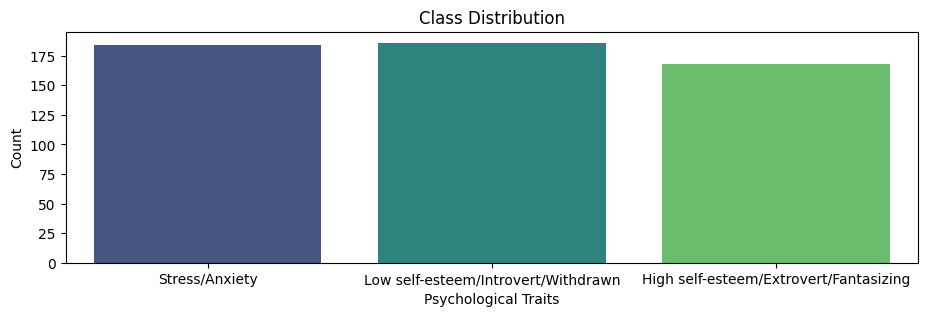

In [5]:
plt.figure(figsize=(11, 3))
sns.countplot(x='class_label', data=df, palette='viridis')
plt.title("Class Distribution")
plt.xlabel("Psychological Traits")
plt.ylabel("Count")
plt.show()


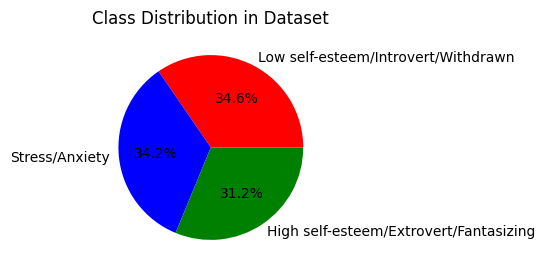

In [6]:
plt.figure(figsize=(3,3))
df['class_label'].value_counts().plot.pie(autopct='%1.1f%%', colors=['red', 'blue', 'green'])
plt.title("Class Distribution in Dataset")
plt.ylabel("")
plt.show()


In [29]:
print("Class value counts:\n", df['class_label'].value_counts())
print("\nClass mean:\n", df['class'].mean())
print("\nClass median:\n", df['class'].median())
print("\nClass mode:\n", df['class'].mode()[0])


Class value counts:
 class_label
Low self-esteem/Introvert/Withdrawn       186
Stress/Anxiety                            184
High self-esteem/Extrovert/Fantasizing    168
Name: count, dtype: int64

Class mean:
 0.9666048237476809

Class median:
 1.0

Class mode:
 1


In [38]:
def count_classes(dictClass, arr):
    """
    Redundant method that counts the occurrences of each class in the dataset
    Can be used to create weights if the class distribution is unbalanced
    :param dictClass: Dictionary that maps number to class labels
    :param arr: The array that contains the data
    :return: The number of occurrences for each class in the given array
    """
    unique, count = numpy.unique(arr, return_counts=True)
    print(dict(zip(dictClass.values(), count)))
    count = 1 / count
    count = count / sum(count)
    return count

In [39]:
# Match the image IDs to the ID values in the .csv file.
translation_dict = dict( zip([f'{id}.png' for id in data['id']], data['class']))

# Prepare each image to be passed as a Tensor product to the model.
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Prepare the data by matching it to its label and transforming it to a Tensor product.
housedata = DoodleDatasetSimple(r'D:\\COLLEGE_STUDIES\\SEM-6\\ML_NLP_project\\images\\house\\', data_transforms, translation_dict)


In [ ]:
train_len = int(housedata.__len__() * 0.8)

test_len = int(housedata.__len__() * 0.2 + 1)

train_set, val_set = torch.utils.data.random_split(housedata, [train_len, test_len])

train_loader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=0, drop_last=True)

test_loader = DataLoader(val_set, batch_size=4, shuffle=False, num_workers=0, drop_last=True)

## Model Definition

In [41]:
class MultilabelClassifier(nn.Module):
    """
    Class that contains the layers for the model.
    Starting model ResNet-34, replace last layer with a Linear layer that outputs
    a single number, the label of the image.
    """
    def __init__(self, n_features):
        super().__init__()
        self.resnet = models.resnet34(pretrained=True)
        self.model_wo_fc = nn.Sequential(*(list(self.resnet.children())[:-1]))

        self.imageClass = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=512, out_features=n_features)
        )

    def forward(self, x):
        x = self.model_wo_fc(x)
        x = torch.flatten(x, 1)

        return {
            'class': self.imageClass(x)
        }
    



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultilabelClassifier(3).to(device)


c:\Users\karti\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\karti\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [43]:
def criterion(outputs, pictures):
    """
    Method used by the model as the criterion for training.
    Cross entropy loss used as the loss function
    :param outputs: Predicted labels by the model
    :param pictures: Actual labeled images from the dataset
    :return: The sum of the cross entropy loss function.
    """
    losses = 0

    for i, key in enumerate(outputs):
        loss_func = nn.CrossEntropyLoss()
        labelsTensor = pictures['class'].clone().detach()
        losses += loss_func(outputs[key], labelsTensor.long().to(device))

    return losses


In [ ]:
def training(model, device, lr_rate, epochs, train_loader):
    """
    Method used by the model for training
    :param model: The model to train
    :param device: Which device to use for computation, GPU or CPU
    :param lr_rate: The learning rate used by the optimizing function
    :param epochs: How many epochs to train the model for
    :param train_loader: The loader that provides the labeled images in batches
    :return: An array containing the losses after each epoch
    """
    num_epochs = epochs
    losses = []
    checkpoint_losses = []

    optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)
    n_total_steps = len(train_loader)

    for epoch in range(num_epochs):
        for i, pictures in enumerate(train_loader):
            images = pictures['image'].to(device)

            output = model(images)

            loss = criterion(output, pictures)
            losses.append(loss.item())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) % (int(n_total_steps / 1)) == 0:
                checkpoint_loss = torch.tensor(losses).mean().item()
                checkpoint_losses.append(checkpoint_loss)
                print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{n_total_steps}], Loss: {checkpoint_loss:.4f}')

    # Save the model in appropriate directory
    model_save_path = r'D:\COLLEGE_STUDIES\SEM-6\ML_NLP_project\model\house\house_model_12.tar'
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': checkpoint_losses,
    }, model_save_path)



    return checkpoint_losses


In [45]:
# Call the method to train the model
checkpoint_losses = training(model, device, 0.0001, 12, train_loader)


Epoch [1/12], Step [107/107], Loss: 0.4728
Epoch [2/12], Step [107/107], Loss: 0.3842
Epoch [3/12], Step [107/107], Loss: 0.2925
Epoch [4/12], Step [107/107], Loss: 0.2659
Epoch [5/12], Step [107/107], Loss: 0.2359
Epoch [6/12], Step [107/107], Loss: 0.2128
Epoch [7/12], Step [107/107], Loss: 0.2005
Epoch [8/12], Step [107/107], Loss: 0.1880
Epoch [9/12], Step [107/107], Loss: 0.1734
Epoch [10/12], Step [107/107], Loss: 0.1581
Epoch [11/12], Step [107/107], Loss: 0.1600
Epoch [12/12], Step [107/107], Loss: 0.1538


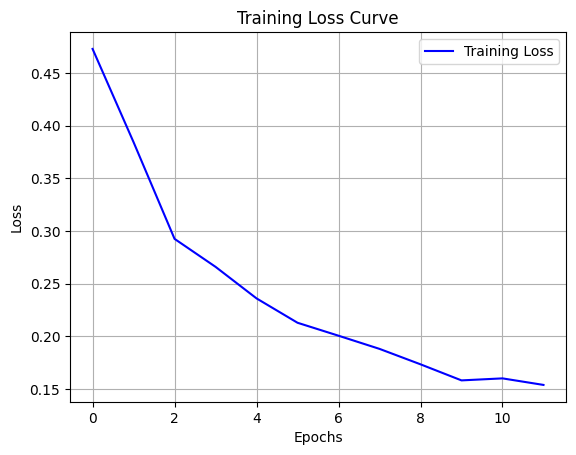

In [46]:
plt.plot(checkpoint_losses, linestyle='-', color='b', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def validation(model, dataloader, device):
    """
    Validates the model after training.

    :param model: The trained model.
    :param dataloader: Dataloader providing labeled images in batches.
    :param device: Device (CPU or GPU) for computation.
    :return: Model accuracy in percentage.
    """
    model.eval()  # Set model to evaluation mode
    n_correct = 0
    n_samples = 0

    with torch.no_grad():
        for pictures in dataloader:
            images = pictures['image'].to(device)
            labels = pictures['class'].to(device)

            outputs = model(images)['class']  
            _, predicted = torch.max(outputs, 1)  

            n_correct += (predicted == labels).sum().item()
            n_samples += labels.size(0)

    acc = 100.0 * n_correct / n_samples if n_samples > 0 else 0.0  
    print(f"Validation Accuracy: {acc:.2f}%")
    
    return acc


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
model.to(device)  

accuracy = validation(model, test_loader, device)

Validation Accuracy: 99.07%


In [ ]:
y_true = []  
y_pred = []  

model.eval()
with torch.no_grad():
    for pictures in test_loader:
        images = pictures['image'].to(device)
        labels = pictures['class'].to(device)

        outputs = model(images)['class']  
        _, predicted = torch.max(outputs, 1) 

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")


print("Sample y_true:", y_true[:10]) 
print("Sample y_pred:", y_pred[:10])  

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Sample y_true: [np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(2), np.int64(2)]
Sample y_pred: [np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(2), np.int64(2), np.int64(2)]
Accuracy: 0.9907
Precision: 0.9910
Recall: 0.9907
F1 Score: 0.9907
